In [1]:
# | hide
# skip
! [ -e /content ] && pip install -Uqq model_inspector nbdev
# For colab. Restart the runtime after running this cell!

In [2]:
# | default_exp inspect.linear_model

# Linear Model

> Inspector functionality specific to linear regression, logistic regression, and their variants

In [3]:
# | export
from typing import Sequence, Union

from fastcore.test import test_fig_exists
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import waterfall_chart
from IPython.display import HTML
from model_inspector.delegate import delegates
from model_inspector.inspect.classifier import _BinInspector, _MultiInspector
from model_inspector.inspect.regressor import _RegInspector
from sklearn.base import clone

In [4]:
# | export
# Meant to be colorblind-friendly
COLORS = {"blue": "#377eb8", "orange": "#ff7f00", "green": "#4daf4a", "pink": "#f781bf"}

In [5]:
# | export
class _LinInspectorMixin:
    """Abstract mixin class for linear model inspectors"""

    def show_model(*args, **kwargs):
        raise NotImplementedError()

    def plot_coefs_vs_hparam(*args, **kwargs):
        raise NotImplementedError()

    def plot_waterfall(*args, **kwargs):
        raise NotImplementedError()

    def _generate_model_html(
        self,
        intercept: float,
        coefs: Sequence[float],
        target_name: str,
        intercept_formatter: str = ".2f",
        coef_formatter: str = ".2f",
    ):
        if len(coefs) != len(self.X.columns):
            raise ValueError("len(coefs) != len(feature_cols)")
        model_string = f"""
            <span style='color:{COLORS["pink"]}'>{target_name}</span>
            = <span style='color:{COLORS["orange"]}'>{intercept:{intercept_formatter}}</span>
        """  # noqa: E501
        for coef, feature_col in zip(coefs, self.X.columns):
            model_string += f"""
                <span style='color:{COLORS["green"]}'>{"+" if coef >= 0 else "-"} {abs(coef):{coef_formatter}}</span>
                * <span style='color:{COLORS["blue"]}'>{feature_col}</span>
            """  # noqa: E501
        return model_string

    def _plot_waterfall(
        self,
        item: Union[pd.Series, np.array],
        intercept: float,
        coefs: Sequence[float],
        y_lab: str,
        bar_num_formatter: str = ".1f",
        tick_num_formatter: str = ".2f",
        sorted_value: bool = True,
        threshold: float = 0.01,
        blue_color=COLORS["blue"],
        green_color=COLORS["green"],
        red_color=COLORS["orange"],
        rotation_value: int = 270,
        **waterfall_kwargs,
    ):
        index = ["int"] + [
            f"{name}: {val:{tick_num_formatter}}"
            for name, val in zip(self.X.columns, item)
        ]
        vals = [intercept] + list(np.array(coefs) * item)
        waterfall_chart.plot(
            index=index,
            data=vals,
            x_lab="Feature name and value",
            y_lab=y_lab,
            formatting=f"{{:,{bar_num_formatter}}}",
            net_label=self.y.name,
            sorted_value=sorted_value,
            threshold=threshold,
            blue_color=blue_color,
            green_color=green_color,
            red_color=red_color,
            rotation_value=rotation_value,
            **waterfall_kwargs,
        )
        return plt.gca()

## Linear Regression

In [6]:
# | export
class _LinRegInspector(_RegInspector, _LinInspectorMixin):
    """Linear regression model inspector"""

    def show_model(
        self,
        intercept_formatter: str = ".2f",
        coef_formatter: str = ".2f",
    ):
        """Show model equation

        Parameters:

        - `intercept_formatter`: Intercept format specifier
        - `coef_formatter`: Intercept format specifier
        """
        return HTML(
            self._generate_model_html(
                intercept=self.model.intercept_,
                coefs=self.model.coef_,
                target_name=self.y.name,
                intercept_formatter=intercept_formatter,
                coef_formatter=coef_formatter,
            )
        )

    def plot_coefs_vs_hparam(self, hparam: str, vals: Sequence[float]):
        """Plot coefficient values against a hyperparameter

        Parameters:

        - `hparam`: Name of hyperparameter; must be an attribute of
        `self.model`
        - `vals`: Values of that hyperparameter to use
        """
        current_val = getattr(self.model, hparam)
        model = clone(self.model)
        setattr(model, hparam, vals[-1])
        model.fit(self.X, self.y)
        column_order = model.coef_.argsort()[::-1]
        X = self.X.iloc[:, column_order]

        coefs = []
        for val in vals:
            setattr(model, hparam, val)
            coefs.append(model.fit(X, self.y).coef_)

        fig, ax = plt.subplots()
        ax.plot(vals, coefs)
        ax.plot([vals.min(), vals.max()], [0, 0], linestyle="dotted", c="k")
        ax.axvline(current_val, c="k", label="current value")
        ax.set(xlabel=hparam, ylabel="coefficient value")
        ax.legend(X.columns, bbox_to_anchor=(1.05, 1.0), loc="upper left")
        return ax

    @delegates(waterfall_chart.plot)
    def plot_waterfall(
        self,
        item: Union[pd.Series, np.array],
        bar_num_formatter: str = ".1f",
        tick_num_formatter: str = ".2f",
        sorted_value=True,
        threshold=0.01,
        blue_color=COLORS["blue"],
        green_color=COLORS["green"],
        red_color=COLORS["orange"],
        **kwargs,
    ):
        """Make a waterfall chart showing how each feature contributes
        to the prediction for the input item.

        Parameters:

        - `item`: Input item, with the same shape and value meanings as
        a single row from `self.X`
        - `bar_num_formatter`: Bar label format specifier
        - `tick_num_formatter`: Tick label format specifier

        Additional keyword arguments will be passed to
        `waterfall_chart.plot`
        """
        return self._plot_waterfall(
            item=item,
            intercept=self.model.intercept_,
            coefs=self.model.coef_,
            y_lab="Contribution to prediction",
            bar_num_formatter=bar_num_formatter,
            tick_num_formatter=tick_num_formatter,
            sorted_value=sorted_value,
            threshold=threshold,
            blue_color=blue_color,
            green_color=green_color,
            red_color=red_color,
            **kwargs,
        )

In [7]:
import sklearn.datasets
from model_inspector import get_inspector
from sklearn.linear_model import Ridge

In [8]:
X, y = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)

inspector = get_inspector(Ridge().fit(X, y), X, y)

In [9]:
# | hide
import warnings

from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, LogisticRegression

In [10]:
# | hide
LINEAR_MODELS = [LinearRegression, LogisticRegression, Ridge, ElasticNet, Lasso]

for model_class in LINEAR_MODELS:
    model = model_class().fit(X, y)
    for method in ["show_model", "plot_coefs_vs_hparam", "plot_waterfall"]:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            assert hasattr(
                get_inspector(model, X, y),
                method,
            )

In [11]:
# | hide
from model_inspector.inspect.linear_model import _LinRegInspector  # noqa: F811

In [12]:
# | hide
assert isinstance(inspector, _LinRegInspector)

In [13]:
# | hide
inspector.methods

['_generate_model_html',
 '_plot_waterfall',
 'permutation_importance',
 'plot_coefs_vs_hparam',
 'plot_feature_clusters',
 'plot_partial_dependence',
 'plot_permutation_importance',
 'plot_pred_vs_act',
 'plot_residuals',
 'plot_waterfall',
 'show_correlation',
 'show_model']

In [14]:
# | hide
from nbdev.showdoc import show_doc

In [15]:
show_doc(
    _LinRegInspector.plot_coefs_vs_hparam,
    name="plot_coefs_vs_hparam (regression model)",
)

---

[source](https://github.com/gsganden/model_inspector/tree/main/blob/main/model_inspector/inspect/linear_model.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### plot_coefs_vs_hparam (regression model)

>      plot_coefs_vs_hparam (regression model) (hparam:str,
>                            vals:Sequence[float])

Plot coefficient values against a hyperparameter

Parameters:

- `hparam`: Name of hyperparameter; must be an attribute of
`self.model`
- `vals`: Values of that hyperparameter to use

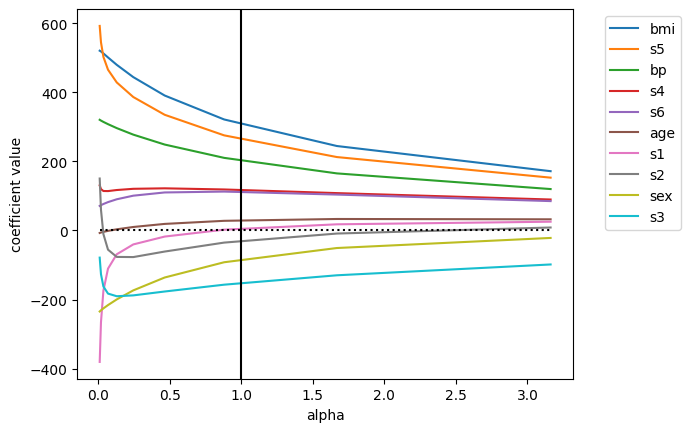

In [16]:
ax = inspector.plot_coefs_vs_hparam("alpha", np.logspace(-2, 0.5, 10))

In [17]:
# | hide
test_fig_exists(ax)

In [18]:
show_doc(_LinRegInspector.plot_waterfall, name="plot_waterfall (regression model)")

---

[source](https://github.com/gsganden/model_inspector/tree/main/blob/main/model_inspector/inspect/linear_model.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### plot_waterfall (regression model)

>      plot_waterfall (regression model)
>                      (item:Union[pandas.core.series.Series,<built-
>                      infunctionarray>], bar_num_formatter:str='.1f',
>                      tick_num_formatter:str='.2f', sorted_value=True,
>                      threshold=0.01, blue_color='#377eb8',
>                      green_color='#4daf4a', red_color='#ff7f00', Title='',
>                      x_lab='', y_lab='', formatting='{:,.1f}',
>                      other_label='other', net_label='net', rotation_value=30)

Make a waterfall chart showing how each feature contributes
to the prediction for the input item.

Parameters:

- `item`: Input item, with the same shape and value meanings as
a single row from `self.X`
- `bar_num_formatter`: Bar label format specifier
- `tick_num_formatter`: Tick label format specifier

Additional keyword arguments will be passed to
`waterfall_chart.plot`

Remaining parameters are passed to `waterfall_chart.plot`.

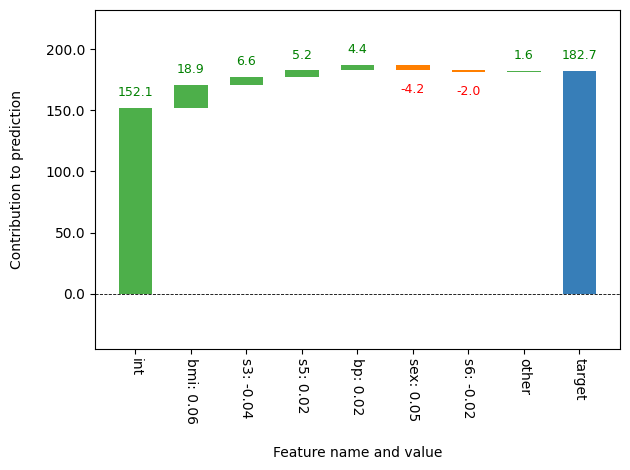

In [19]:
ax = inspector.plot_waterfall(X.iloc[0])

In [20]:
# | hide
test_fig_exists(ax)

In [21]:
show_doc(_LinRegInspector.show_model, name="show_model (regression model)")

---

[source](https://github.com/gsganden/model_inspector/tree/main/blob/main/model_inspector/inspect/linear_model.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### show_model (regression model)

>      show_model (regression model) (intercept_formatter:str='.2f',
>                  coef_formatter:str='.2f')

Show model equation

Parameters:

- `intercept_formatter`: Intercept format specifier
- `coef_formatter`: Intercept format specifier

In [22]:
inspector.show_model()

## Binary Logistic Regression

In [23]:
# | export
class _LinBinInspector(_BinInspector, _LinInspectorMixin):
    """Linear binary classification model inspector"""

    def plot_coefs_vs_hparam(self, hparam: str, vals: Sequence[float]) -> np.array:
        """Plot coefficient values against a hyperparameter

        Parameters:

        - `hparam`: Name of hyperparameter; must be an attribute of
        `self.model`
        - `vals`: Values of that hyperparameter to use
        """
        current_val = getattr(self.model, hparam)
        model = clone(self.model)
        setattr(model, hparam, vals[-1])
        column_order = model.fit(self.X, self.y).coef_[0].argsort()[::-1]
        X = self.X.iloc[:, column_order]

        coef_arrays = []
        for val in vals:
            setattr(model, hparam, val)
            coef_arrays.append(model.fit(X, self.y).coef_)

        fig, ax = plt.subplots()
        ax.plot(vals, [coefs[0] for coefs in coef_arrays])
        ax.plot([vals.min(), vals.max()], [0, 0], linestyle="dotted", c="k")
        ax.set(xlabel=hparam, ylabel="Coefficient Value")
        ax.axvline(current_val, c="k", label="current value")
        ax.legend(X.columns, bbox_to_anchor=(1.05, 1.0), loc="upper left")
        return ax

    def show_model(
        self,
        intercept_formatter: str = ".2f",
        coef_formatter: str = ".2f",
    ):
        """Show model equation

        Parameters:

        - `intercept_formatter`: Intercept format specifier
        - `coef_formatter`: Intercept format specifier
        """
        return HTML(
            self._generate_model_html(
                intercept=self.model.intercept_[0],
                coefs=self.model.coef_[0],
                target_name=f"log-odds({self.y.name})",
                intercept_formatter=intercept_formatter,
                coef_formatter=coef_formatter,
            )
        )

    @delegates(waterfall_chart.plot)
    def plot_waterfall(
        self,
        item: Union[pd.Series, np.array],
        bar_num_formatter: str = ".1f",
        tick_num_formatter: str = ".2f",
        sorted_value=True,
        threshold=0.01,
        blue_color=COLORS["blue"],
        green_color=COLORS["green"],
        red_color=COLORS["orange"],
        **kwargs,
    ):
        """Make a waterfall chart showing how each feature contributes
        to the prediction for the input item for a binary classification
        model.

        Parameters:

        - `item`: Input item, with the same shape and value meanings as
        a single row from `self.X`
        - `bar_num_formatter`: Bar label format specifier
        - `tick_num_formatter`: Tick label format specifier
        - `waterfall_kwargs`: kwargs to pass to `waterfall_chart.plot`
        """
        return self._plot_waterfall(
            item=item,
            intercept=self.model.intercept_[0],
            coefs=self.model.coef_[0],
            y_lab="Contribution to predicted log-odds",
            bar_num_formatter=bar_num_formatter,
            tick_num_formatter=tick_num_formatter,
            sorted_value=sorted_value,
            threshold=threshold,
            blue_color=blue_color,
            green_color=green_color,
            red_color=red_color,
            **kwargs,
        )

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
X, y = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)
X = X.iloc[:, :10]

In [26]:
inspector = get_inspector(LogisticRegression(max_iter=1_000).fit(X, y), X, y)

In [27]:
# | hide
from model_inspector.inspect.linear_model import _LinBinInspector  # noqa: F811

In [28]:
# | hide
assert isinstance(inspector, _LinBinInspector)

In [29]:
show_doc(
    _LinBinInspector.plot_coefs_vs_hparam, name="plot_coefs_vs_hparam (binary model)"
)

---

[source](https://github.com/gsganden/model_inspector/tree/main/blob/main/model_inspector/inspect/linear_model.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### plot_coefs_vs_hparam (binary model)

>      plot_coefs_vs_hparam (binary model) (hparam:str, vals:Sequence[float])

Plot coefficient values against a hyperparameter

Parameters:

- `hparam`: Name of hyperparameter; must be an attribute of
`self.model`
- `vals`: Values of that hyperparameter to use

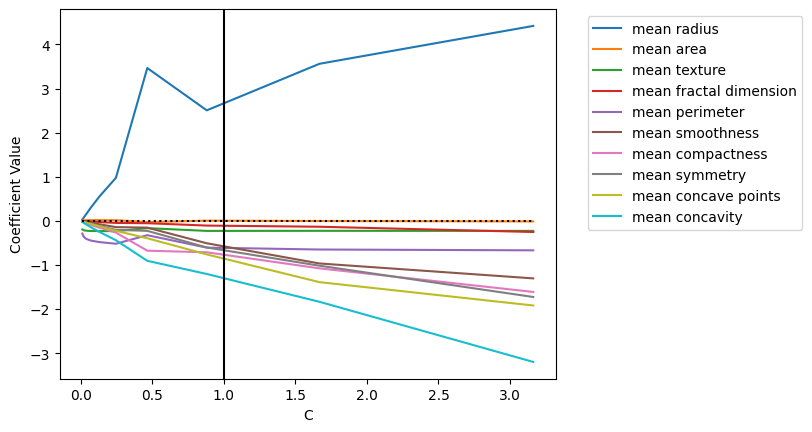

In [30]:
ax = inspector.plot_coefs_vs_hparam("C", np.logspace(-2, 0.5, 10))

In [31]:
# | hide
test_fig_exists(ax)

In [32]:
show_doc(_LinBinInspector.show_model, name="show_model (binary model)")

---

[source](https://github.com/gsganden/model_inspector/tree/main/blob/main/model_inspector/inspect/linear_model.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### show_model (binary model)

>      show_model (binary model) (intercept_formatter:str='.2f',
>                  coef_formatter:str='.2f')

Show model equation

Parameters:

- `intercept_formatter`: Intercept format specifier
- `coef_formatter`: Intercept format specifier

In [33]:
inspector.show_model()

In [34]:
show_doc(_LinBinInspector.plot_waterfall, name="plot_waterfall (binary model)")

---

[source](https://github.com/gsganden/model_inspector/tree/main/blob/main/model_inspector/inspect/linear_model.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### plot_waterfall (binary model)

>      plot_waterfall (binary model)
>                      (item:Union[pandas.core.series.Series,<built-
>                      infunctionarray>], bar_num_formatter:str='.1f',
>                      tick_num_formatter:str='.2f', sorted_value=True,
>                      threshold=0.01, blue_color='#377eb8',
>                      green_color='#4daf4a', red_color='#ff7f00', Title='',
>                      x_lab='', y_lab='', formatting='{:,.1f}',
>                      other_label='other', net_label='net', rotation_value=30)

Make a waterfall chart showing how each feature contributes
to the prediction for the input item for a binary classification
model.

Parameters:

- `item`: Input item, with the same shape and value meanings as
a single row from `self.X`
- `bar_num_formatter`: Bar label format specifier
- `tick_num_formatter`: Tick label format specifier
- ``waterfall_kwargs`: kwargs to pass to `waterfall_chart.plot`

Remaining parameters are passed to `waterfall_chart.plot`.

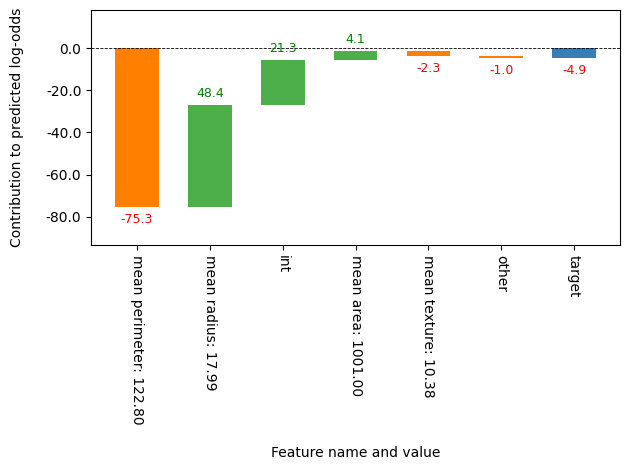

In [35]:
ax = inspector.plot_waterfall(X.iloc[0])

In [36]:
# | hide
test_fig_exists(ax)

## Multiclass Logistic Regression

In [37]:
# | export
class _LinMultiInspector(_MultiInspector, _LinInspectorMixin):
    """Linear multiclass classification model inspector"""

    def plot_coefs_vs_hparam(self, hparam: str, vals: Sequence[float]) -> NDArray[Axes]:
        """Plot coefficient values against a hyperparameter

        Parameters:

        - `hparam`: Name of hyperparameter; must be an attribute of
        `self.model`
        - `vals`: Values of that hyperparameter to use
        """
        current_val = getattr(self.model, hparam)
        model = clone(self.model)
        setattr(model, hparam, vals[-1])
        column_order = model.fit(self.X, self.y).coef_[0].argsort()[::-1]
        X = self.X.iloc[:, column_order]

        coef_arrays = []
        for val in vals:
            setattr(model, hparam, val)
            coef_arrays.append(model.fit(X, self.y).coef_)

        num_target_vals = len(set(self.y))

        fig, axes = plt.subplots(
            num_target_vals, 1, sharex=True, sharey=True, constrained_layout=True
        )
        for target_val_num in range(num_target_vals):
            axes[target_val_num].plot(
                vals, [coefs[target_val_num] for coefs in coef_arrays]
            )
            axes[target_val_num].set_title(f"y={sorted(set(self.y))[target_val_num]}")
        axes[0].set(xlabel=hparam, ylabel="Coefficient Value")
        for ax in axes:
            ax.axvline(current_val, c="k", label="current value")
            ax.plot([vals.min(), vals.max()], [0, 0], linestyle="dotted", c="k")
        axes[0].legend(X.columns, bbox_to_anchor=(1.05, 1.0), loc="upper left")
        return axes

    def show_model(
        self,
        intercept_formatter: str = ".2f",
        coef_formatter: str = ".2f",
    ):
        """Show model equation

        Parameters:

        - `intercept_formatter`: Intercept format specifier
        - `coef_formatter`: Intercept format specifier
        """
        model_string = ""
        for target_name, coefs, intercept in zip(
            np.unique(self.y), self.model.coef_, self.model.intercept_
        ):
            model_string += f"""
                    <p>
                        {self._generate_model_html(
                                intercept=intercept,
                                coefs=coefs,
                                target_name=f"log-odds({self.y.name} = {target_name})",
                                intercept_formatter=intercept_formatter,
                                coef_formatter=coef_formatter,
                            )
                        }
                    </p>
                """
        return HTML(model_string)

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
X, y = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)

In [40]:
inspector = get_inspector(LogisticRegression(max_iter=10_000).fit(X, y), X, y)

In [41]:
# | hide
from model_inspector.inspect.linear_model import _LinMultiInspector  # noqa: F811

In [42]:
# | hide
assert isinstance(inspector, _LinMultiInspector)

In [43]:
show_doc(
    _LinMultiInspector.plot_coefs_vs_hparam,
    name="plot_coefs_vs_hparam (multiclass model)",
)

---

[source](https://github.com/gsganden/model_inspector/tree/main/blob/main/model_inspector/inspect/linear_model.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### plot_coefs_vs_hparam (multiclass model)

>      plot_coefs_vs_hparam (multiclass model) (hparam:str,
>                            vals:Sequence[float])

Plot coefficient values against a hyperparameter

Parameters:

- `hparam`: Name of hyperparameter; must be an attribute of
`self.model`
- `vals`: Values of that hyperparameter to use

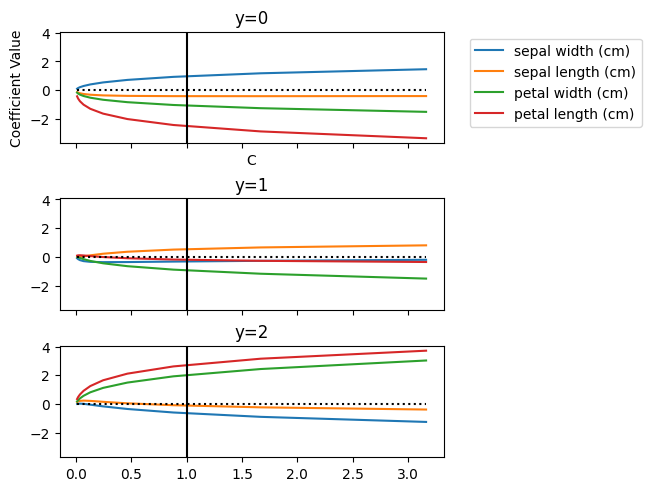

In [44]:
axes = inspector.plot_coefs_vs_hparam("C", np.logspace(-2, 0.5, 10))

In [45]:
# | hide
test_fig_exists(axes[0])

In [46]:
show_doc(_LinMultiInspector.show_model, name="show_model (multiclass model)")

---

[source](https://github.com/gsganden/model_inspector/tree/main/blob/main/model_inspector/inspect/linear_model.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### show_model (multiclass model)

>      show_model (multiclass model) (intercept_formatter:str='.2f',
>                  coef_formatter:str='.2f')

Show model equation

Parameters:

- `intercept_formatter`: Intercept format specifier
- `coef_formatter`: Intercept format specifier

In [47]:
inspector.show_model()

In [48]:
# | export
_all_ = ["_LinRegInspector", "_LinBinInspector", "_LinMultiInspector"]